# BEC and Thermal Cloud NN

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
from generate_bec_thermal_cloud_nn_data import GenerateBecThermalCloudData
from matplotlib.colors import LogNorm

## Calculate Transition Temperature

In [2]:
num_atoms = 100000
#calculate transition temperature

trans_temp = (num_atoms/(2*1*1.645))**0.5
print(trans_temp)

174.34201093860167


## Generate Training and Test Data

In [ ]:
#training data size, test data size, noise spread, resolution length, number of atoms, transition temperature 

#current temps are {0:87,1:125,2:150,3:280}

#500 noise spread can get 98% accuracy
generate = GenerateBecThermalCloudData(10000,5000,0,100,100000,trans_temp)

--- 2.09808349609375e-05 seconds ---


#### Split Test Data into Validation Data and Final Test Data

In [11]:
validation_x = generate.x_test[len(generate.x_test)//2:]
x_test = generate.x_test[:len(generate.x_test)//2]

validation_y = generate.y_test[len(generate.y_test)//2:]
y_test = generate.y_test[:len(generate.y_test)//2]

print(np.shape(y_test))

(250, 2)


#### See What Data Images Look Like

(219.98081629464028, 0)


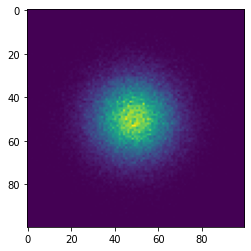

In [12]:
# T = 170
plt.imshow(generate.x_train[1],cmap = "viridis")
print(generate.y_train[2])

In [ ]:
#plt.scatter(generate.x_train[0][0])
plt.scatter(np.arange(len(generate.x_train[0][0])),generate.x_train[3][50])

In [ ]:
plt.plot(np.arange(len(generate.x_train[0][0])),generate.x_train[0][50],label = "Center of Image")
plt.plot(np.arange(len(generate.x_train[0][0])),generate.x_train[0][45],label = "Edge of Image")
plt.legend(loc='upper left')
plt.xlabel("Image Pixel")
plt.ylabel("Atom Cloud Density")

In [ ]:
N=100000

def getN_ex(temp,trans_temp):
    if temp>=trans_temp:
        return N
    else:
        return N*(temp/trans_temp)**2
    
def getN_o(temp,trans_temp):
    if temp>=trans_temp:
        return 0
    else:
        return N*(1-(temp/trans_temp)**2)

temps=np.arange(trans_temp+100)

N_ex_arr = []
N_o_arr = []
for temp in temps:
    N_ex_arr.append(getN_ex(temp,trans_temp))
    N_o_arr.append(getN_o(temp,trans_temp))

plt.plot(temps,N_ex_arr,label="Thermal Cloud")
plt.plot(temps,N_o_arr,label = "BEC")
plt.legend(loc='center right')
x=[175]
labels = ['T_c']
plt.xticks(x, labels, rotation='horizontal')
plt.xlabel("Temperature")
plt.ylabel("Number of Particles")

## Compile Feed Forward NN

#### Discrete Temperature Values Basic NN

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optim,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Continuous Temperature Values Basic NN

##### NN for Temperatures Greater than the Transition Temperature

In [57]:
#on 1000 training images, 250 validation images, and 250 test images, model achieved 0.033 root mean sqr error on test images

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5000,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(2500,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1000,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(500,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(100,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(2,activation= tf.nn.relu))

#0.000001 lr works well for temp only

optim = tf.keras.optimizers.Adam(learning_rate = 0.00001)

model.compile(optimizer=optim,loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

#### Discrete Temperature Values Convolutional NN

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(kernel_size=3,filters=12,use_bias=False,padding='same'))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Conv2D(kernel_size=6,filters=24,use_bias=False,padding='same',strides=2))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))


model.add(tf.keras.layers.Conv2D(kernel_size=6,filters=32,use_bias=False,padding='same',strides=2))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,use_bias=False))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

x_train = np.asarray(generate.x_train)
x_test = np.asarray(generate.x_test)

x_test = x_test.reshape((x_test.shape[0], 100, 100, 1)).tolist()
x_train = x_train.reshape((x_train.shape[0], 100, 100, 1)).tolist()

#### Continuous Temperature Values Convolutional NN

In [ ]:
#isn't working great right now. needs tweaking
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(kernel_size=10,filters=12, activation='relu', input_shape=(100, 100, 1)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))


optim = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optim,loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])


generate.x_train = np.asarray(generate.x_train)
x_test = np.asarray(x_test)
validation_x = np.asarray(validation_x)

generate.x_train = generate.x_train.reshape((generate.x_train.shape[0], 100, 100, 1)).tolist()
x_test = x_test.reshape((x_test.shape[0], 100, 100, 1)).tolist()
validation_x = validation_x.reshape((validation_x.shape[0], 100, 100, 1)).tolist()

batch_size = 128

steps_per_epoch = len(generate.x_train)//batch_size

## Train Model

#### Continuous Temperature Training For Basic NN

In [58]:
#on 1000 training images, 250 validation images, and 250 test images, model achieved 0.033 root mean sqr error on test images

# lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.000005 * math.pow(0.99,epoch), verbose=False)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5,restore_best_weights = True)

model.fit(generate.x_train,generate.y_train,epochs=10000,validation_data = (validation_x,validation_y))#,callbacks = [earlystopping])#,lr_decay_callback])

Epoch 1/10000


2022-08-18 13:14:47.494981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 6s 168ms/step - loss: 380931680.0000 - root_mean_squared_error: 19517.4727 - mean_absolute_error: 7432.7910 - val_loss: 398136864.0000 - val_root_mean_squared_error: 19953.3672 - val_mean_absolute_error: 7900.7285
Epoch 2/10000


2022-08-18 13:14:52.891600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 57ms/step - loss: 340027200.0000 - root_mean_squared_error: 18439.8281 - mean_absolute_error: 7379.8442 - val_loss: 327173568.0000 - val_root_mean_squared_error: 18087.9414 - val_mean_absolute_error: 7795.2622
Epoch 3/10000
32/32 [==============================] - 2s 56ms/step - loss: 246578560.0000 - root_mean_squared_error: 15702.8213 - mean_absolute_error: 7358.7192 - val_loss: 200177808.0000 - val_root_mean_squared_error: 14148.4219 - val_mean_absolute_error: 7382.3047
Epoch 4/10000
32/32 [==============================] - 2s 56ms/step - loss: 121501112.0000 - root_mean_squared_error: 11022.7539 - mean_absolute_error: 6105.5205 - val_loss: 63370000.0000 - val_root_mean_squared_error: 7960.5278 - val_mean_absolute_error: 4562.2451
Epoch 5/10000
32/32 [==============================] - 2s 57ms/step - loss: 23358314.0000 - root_mean_squared_error: 4833.0439 - mean_absolute_error: 2786.7607 - val_loss: 9510388.0000 - val_root_mean_squared_err

KeyboardInterrupt: 

#### Continuous Temperature Training For Convolutional NN

In [ ]:
#not quite accurate yet. needs tweaking
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 20,restore_best_weights = True)
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * math.pow(0.999,epoch), verbose=True)


model.fit(generate.x_train,generate.y_train,batch_size = batch_size,epochs=1000,steps_per_epoch = steps_per_epoch,validation_data = (validation_x,validation_y),callbacks = [earlystopping])#,lr_decay_callback])

## Evaluate Results

#### Discrete Accuracy

In [ ]:
val_loss, val_acc = model.evaluate(generate.x_test,generate.y_test)
print("loss: ",val_loss,"\n","accuracy: ",val_acc)

#### Continuous Accuracy

In [39]:
val_loss, val_rmse, val_mae = model.evaluate(x_test,y_test)
print("loss: ",val_loss,"\n","rmse: ",val_rmse,"\n","mae: ",val_mae)

8/8 [==============================] - 0s 9ms/step - loss: 575925.1875 - root_mean_squared_error: 758.8974 - mean_absolute_error: 148.0214
loss:  575925.1875 
 rmse:  758.8973999023438 
 mae:  148.0214080810547


## See Predictions

#### Continuous Predictions

In [40]:
#not really a great representation, but you can see the predicted scatterplot over correct scatterplot

predictions = model.predict(x_test)
temp_predictions = []
BEC_atoms_predictions = []

temp_test = []
BEC_atoms_test = []
for i in range(len(predictions)):
    
    temp_predictions.append(predictions[i][0])
    BEC_atoms_predictions.append(predictions[i][1])
    
    temp_test.append(y_test[i][0])
    BEC_atoms_test.append(y_test[i][1])

8/8 [==============================] - 0s 10ms/step


2022-08-18 12:40:16.965670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


#### Temperature Plot

Text(0, 0.5, 'y')

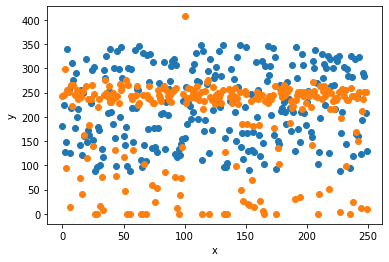

In [41]:
plt.scatter(np.arange(len(temp_test)),temp_test)
plt.scatter(np.arange(len(temp_predictions)),temp_predictions)
plt.xlabel("x")
plt.ylabel("y")

#### Number of Atoms in BEC Plot

Text(0, 0.5, 'y')

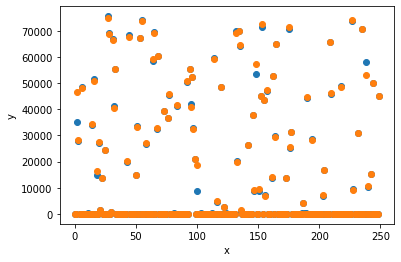

In [42]:
plt.scatter(np.arange(len(BEC_atoms_predictions)),BEC_atoms_predictions)
plt.scatter(np.arange(len(BEC_atoms_test)),BEC_atoms_test)
plt.xlabel("x")
plt.ylabel("y")